# Analiza ofert wynajmu mieszkań we Wrocławiu na podstawie danych serwisu OTODOM
## Problem Biznesowy
Problem biznesowy który zdecydowaliśmy się przeanalizować, polegał na sprawdzeniu, które z następujących udogodnień (bądź ich kombinacji) jest najbardziej opłacalna dla potencjalnego własciciela, przy wynajmie mieszkania; Które z następujących udogodnień, najbardziej podnosi cenę najmu mieszkania:
* Zmywarka
* Lodowka
* Meble
* Piekarnik
* Kuchenka
* Pralka
* Telewizor
* Telewizja kablowa
* Internet
* Telefon

## Metoda analizy
Dane zostały przeanalizowane przez model regresji liniowej, używając modelu liniowego z biblioteki *scikit-learn* - model oblicza współczynnik zmiany ceny. Dane zostały wczytane z pliku .csv do struktury *dataframe* z biblioteki *pandas*. W ramach analizy przeanalizowaliśmy następująco:
* Wzrost ceny w zależności od udogodnienia.
* Wzrost ceny za $m^2$ w zależności od udogodnienia.
* Wzrost ceny w zależności od kombinacji 2 udogodnień.
* Wzrost ceny za $m^2$ w zależności od kombinacji 2 udogodnień.

W celu analizy ceny za metr kwadratowy do ramki danych dodaliśmy kolumnę *cena_za_m2*. Z ramki danych usunęliśmy wszystkie pozycje które mogły miec pustą cenę/ powierzchnię. Stwierdziliśmy że warto także zliczać ilość występowania udogodnień oraz ich kombinacji.

In [64]:
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


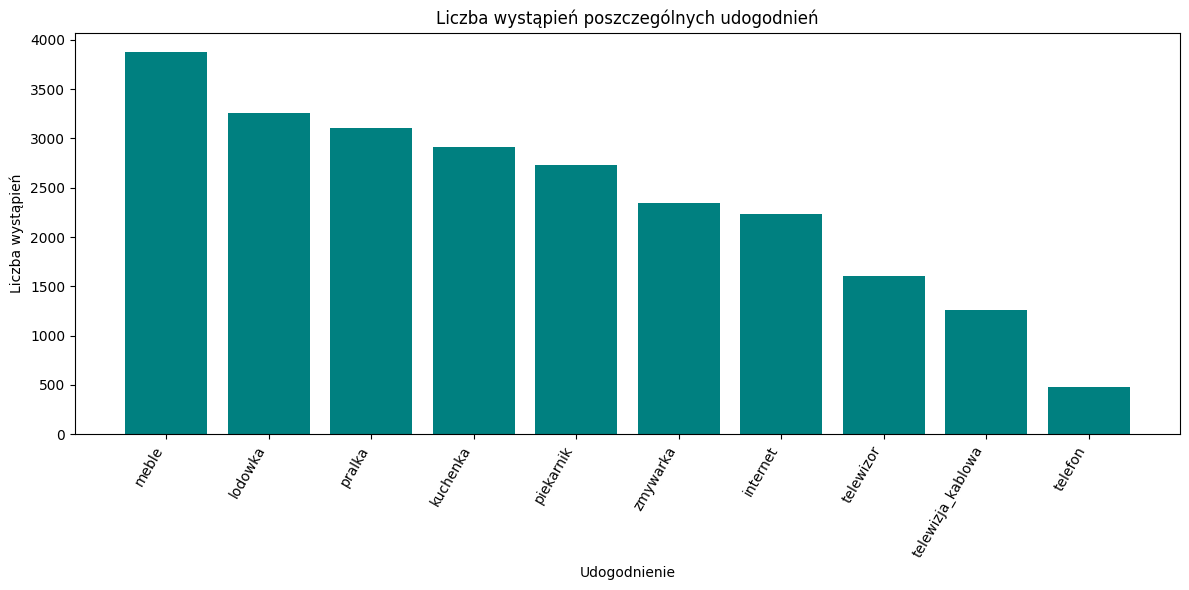

In [65]:


df = pd.read_csv("otodom_all.csv", sep=';', engine='python')

df = df.dropna(subset=['cenaPLN', 'powierzchnia_mkw'])
df['cena_za_m2'] = df['cenaPLN'] / df['powierzchnia_mkw']

features = [
    'zmywarka', 'lodowka', 'meble', 'piekarnik', 'kuchenka',
    'pralka', 'telewizor', 'telewizja_kablowa', 'internet', 'telefon'
]

freq = {}
for feature in features:
    freq[feature] = df[feature].sum()

freq_df = pd.DataFrame.from_dict(freq, orient='index', columns=['wystąpienia'])
freq_df = freq_df.sort_values(by='wystąpienia', ascending=False)
freq_df

plt.figure(figsize=(12, 6))
plt.bar(freq_df.index, freq_df['wystąpienia'], color='teal')
plt.xlabel('Udogodnienie')
plt.ylabel('Liczba wystąpień')
plt.title('Liczba wystąpień poszczególnych udogodnień')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

### Kombinacje udogodnień
Istnieje $\left( \begin{array}{c} 10 \\ 2 \end{array} \right) = \frac{10!}{2!(10-2)!} = \frac{10 * 9}{2} = 45$ kombinacji dwóch udogodnień. Żeby nie musieć spisywać ręcznie każdej z nich, uzyliśmy biblioteki *itertools* w celu wygenerowania wszystkich kombinacji automatycznie. Z każdej z nich powstała nowa kolumna zawierająca wynik mnożenia boolowskiego: 

***df['telefon_telewizor']*** = ***df['telefon']*** * ***df['telewizor']***

Pozwala to uzyskać współczynnik zmiany dla mieszkań które zawierają taką kombinację udogodnień. Najlepsze wyniki uzyskuje się licząc oddzielnie 4 warianty przypadków, wymienionych wyżej.


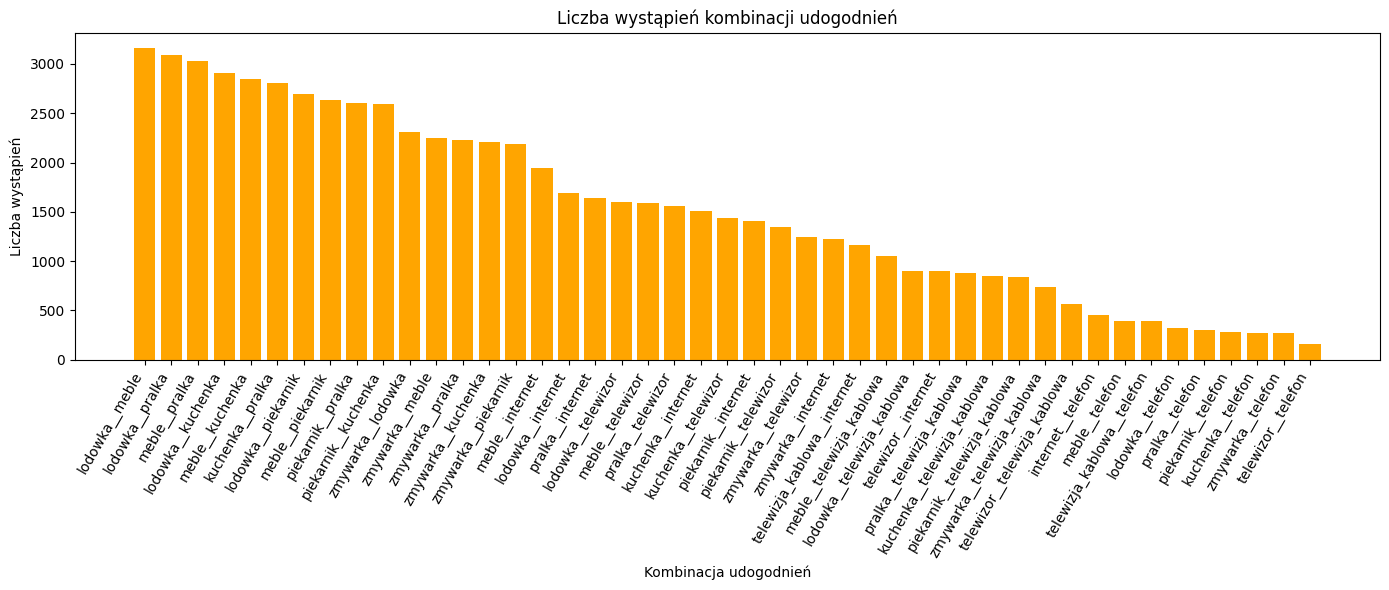

In [66]:
pairs = list(itertools.combinations(features, 2))

pair_freq = {}
for f1, f2 in pairs:
    colname = f"{f1}__{f2}"
    df[colname] = df[f1] * df[f2]
    pair_freq[colname] = df[colname].sum()

freq_df = pd.DataFrame.from_dict(pair_freq, orient='index', columns=['wystąpienia'])
freq_df = freq_df.sort_values(by='wystąpienia', ascending=False)
freq_df


plt.figure(figsize=(14, 6))
plt.bar(freq_df.index, freq_df['wystąpienia'], color='orange')
plt.xlabel('Kombinacja udogodnień')
plt.ylabel('Liczba wystąpień')
plt.title('Liczba wystąpień kombinacji udogodnień')
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


## Dane ofert
Dane na podstawie których robiliśmy analizę zawierały wiele nieużytych przez nas kolumn. Wszystkie użyte przez nas kolumny zawierały tylko wartości liczbowe - łatwe do zrozumienia przez prymitywny model nauczania maszynowego, którego użyliśmy w celu wykonania tej analizy. Udogodnienia oznaczone są 0 w przypadku gdy ich nie ma, oraz 1 w przypadku gdy są. Inne użyte przez nas kolumny (czynsz, metraż w $m^2$).

## Wpływ udogodnień na cenę


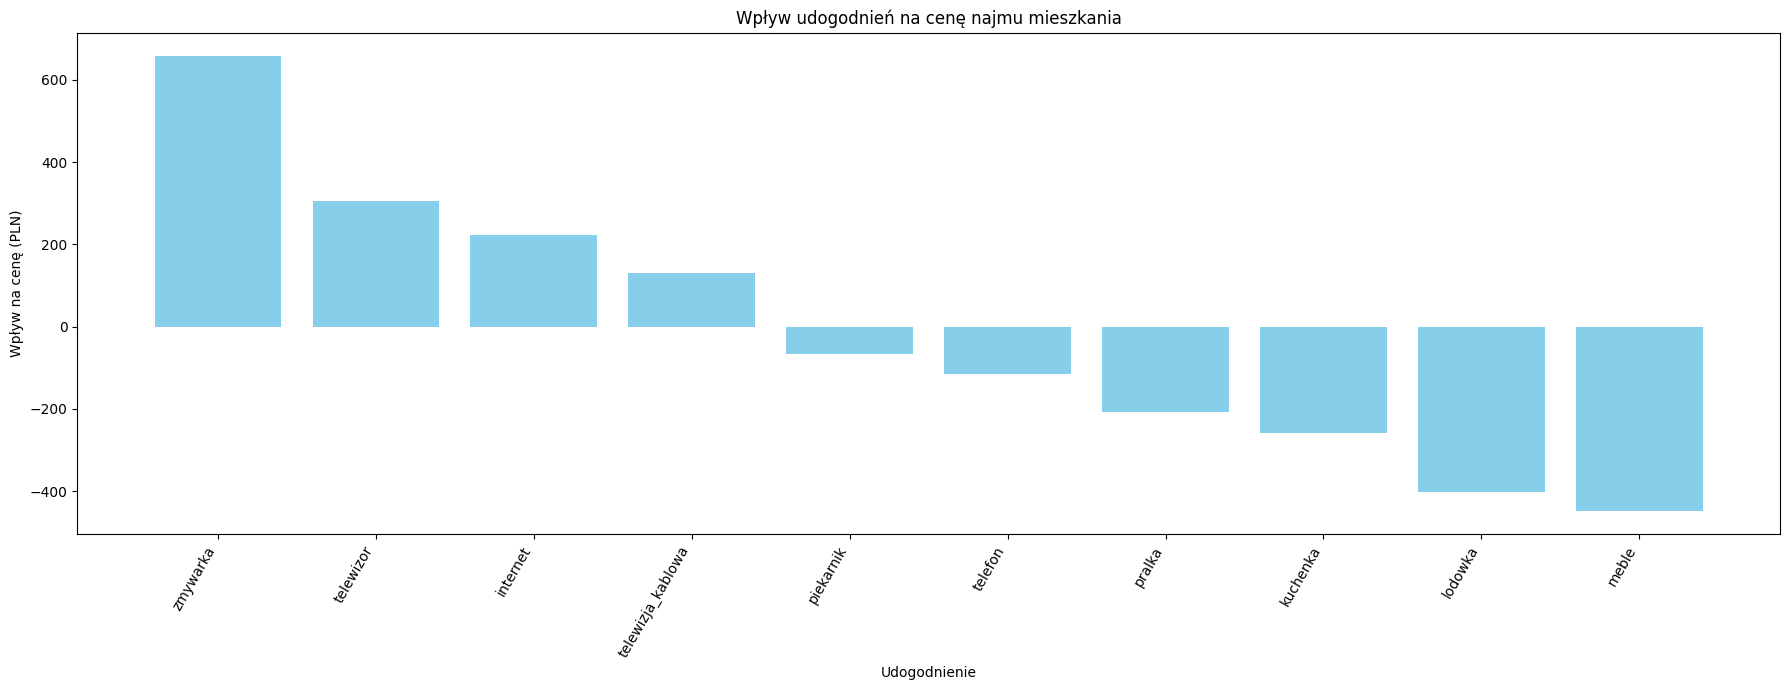

In [67]:
X = df[features]
y = df['cenaPLN']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'udogodnienie': X.columns,
    'wplyw_na_cene': model.coef_,
    'liczba_wystapien': [freq[col] for col in X.columns]
}).sort_values(by='wplyw_na_cene', ascending=False)
results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['udogodnienie'], results['wplyw_na_cene'], color='skyblue')
plt.xlabel('Udogodnienie')
plt.ylabel('Wpływ na cenę (PLN)')
plt.title('Wpływ udogodnień na cenę najmu mieszkania')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()

Udogodnieniem najbardziej wpływającym na czynsze okazała się zmywarka, a najbardziej szkodliwym - lodówka. Najrzadszym z udogodnień okazał się telefon - może sprawić że wyniki będą bardzo przechylone w którymś kierunku - szczególnie w przypadku kombinacji.

## Wpływ udogodnień na cenę za $m^2$

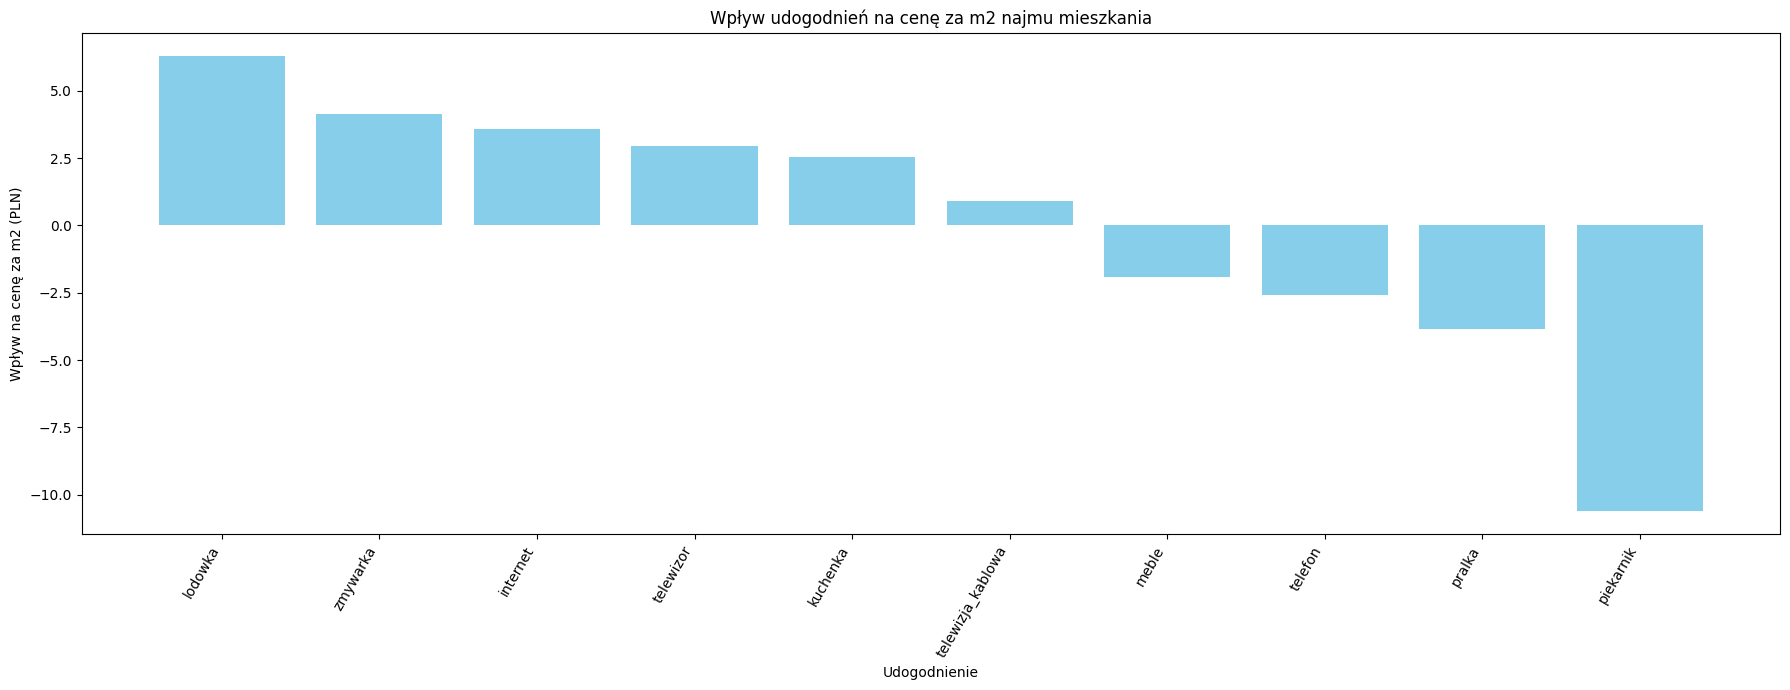

In [68]:
X = df[features]
y = df['cena_za_m2']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'udogodnienie': X.columns,
    'wplyw_na_cene_m2': model.coef_,
    'liczba_wystapien': [freq[col] for col in X.columns]
}).sort_values(by='wplyw_na_cene_m2', ascending=False)
results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['udogodnienie'], results['wplyw_na_cene_m2'], color='skyblue')
plt.xlabel('Udogodnienie')
plt.ylabel('Wpływ na cenę za m2 (PLN)')
plt.title('Wpływ udogodnień na cenę za m2 najmu mieszkania')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()


Odwrotną obserwację, w porównaniu do poprzednich można zobaczyć, gdy będziemy analizowac nie cenę, ale cenę za $m^2$. W tym wypadku okazuje się że to lodówka jest najbardziej opłacalnym udogodnieniem, w jakie można zainwestować, a zmywarka zajmuje 2 miejsce. Piekarnik przynosi dużą szkodę ponad 10 złotych na metr kwadratowy do czynszu. Takie wyniki mogą wynikać z częstszego występowania lodówek, szczególnie w przypadku mieszkań z niższymi czynszami.

## Wpływ kombinacji udogodnień na cenę

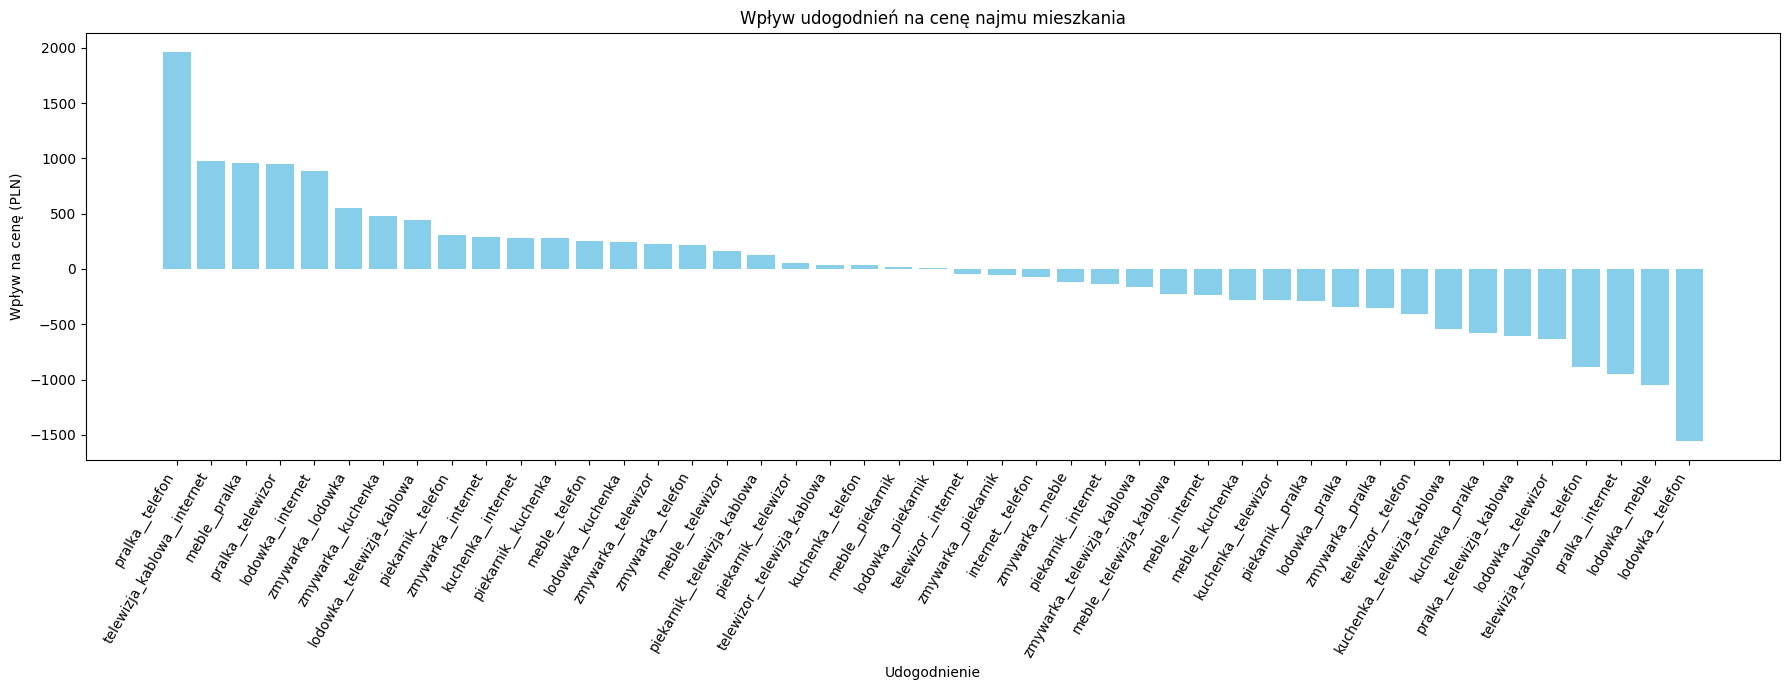

In [69]:
X = df[[f"{f1}__{f2}" for f1, f2 in pairs]]
y = df['cenaPLN']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'para': X.columns,
    'wplyw_na_cene': model.coef_,
    'liczba_wystapien': [pair_freq[col] for col in X.columns]
}).sort_values(by='wplyw_na_cene', ascending=False)
results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['para'], results['wplyw_na_cene'], color='skyblue')
plt.xlabel('Udogodnienie')
plt.ylabel('Wpływ na cenę (PLN)')
plt.title('Wpływ udogodnień na cenę najmu mieszkania')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()


Jak zostało wspomniane wcześniej, telefon może przechylać wyniki, w obie strony, z powodu małej liczby wystąpień. Najbardziej opłacalnymi kombinacjami udogodnień są:
* Pralka i Telefon
* Telewizja kablowa i internet
* Meble i Pralka
* Pralka i Telewizor
* Lodówka i Internet

A takie połączenia jak lodówka z telefonem, bądź meblami są w stanie spowodować dużą stratę na czynszu.

## Wpływ kombinacji udogodnień na cenę za $m^2$

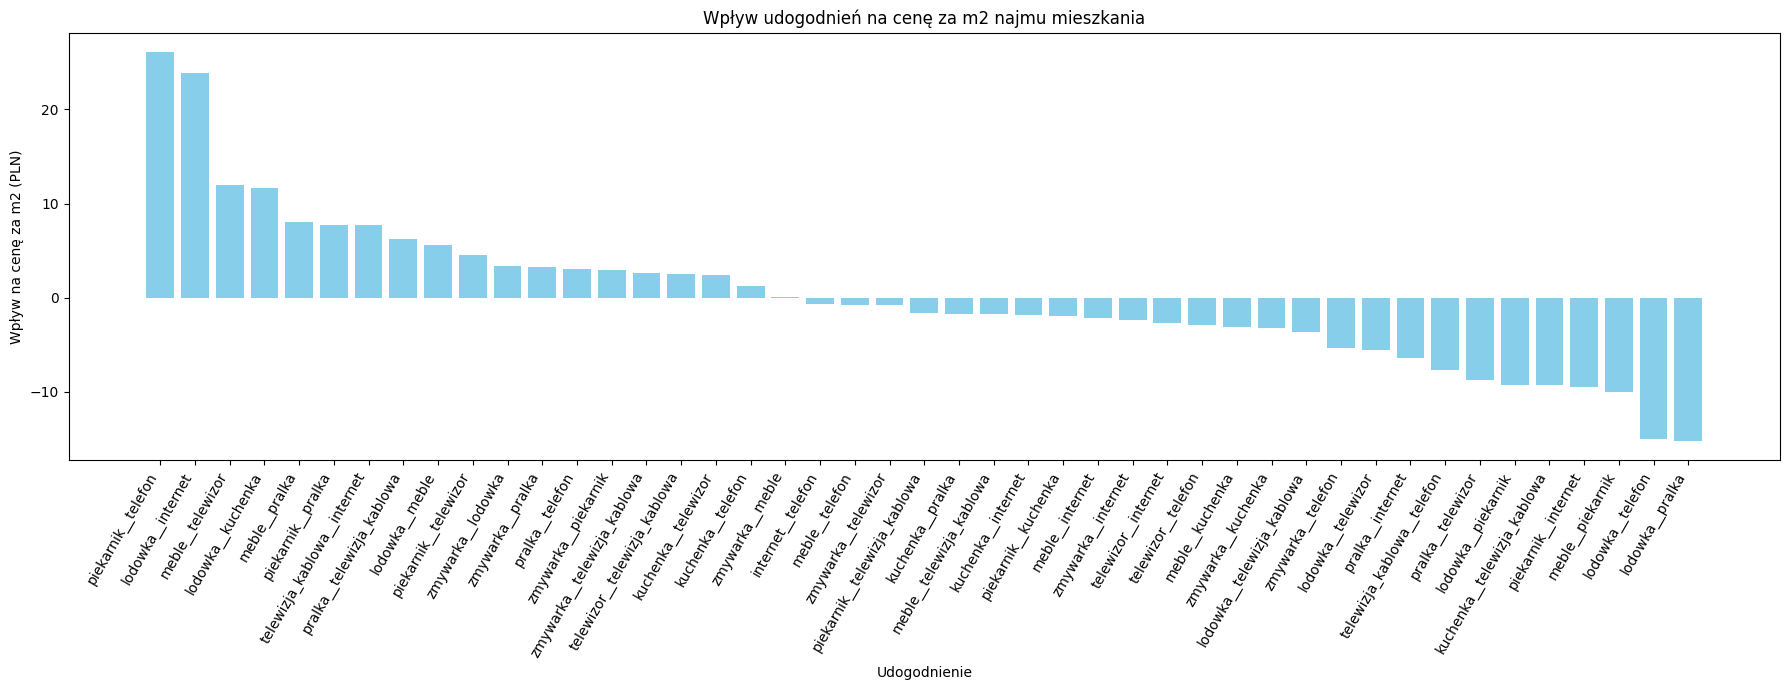

In [70]:
X = df[[f"{f1}__{f2}" for f1, f2 in pairs]]
y = df['cena_za_m2']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'para': X.columns,
    'wplyw_na_cene_m2': model.coef_,
    'liczba_wystapien': [pair_freq[col] for col in X.columns]
}).sort_values(by='wplyw_na_cene_m2', ascending=False)
results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['para'], results['wplyw_na_cene_m2'], color='skyblue')
plt.xlabel('Udogodnienie')
plt.ylabel('Wpływ na cenę za m2 (PLN)')
plt.title('Wpływ udogodnień na cenę za m2 najmu mieszkania')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()

W przypadku sprawdzania cen za $m^2$ sytuacja opłacalności się zmienia: najbardziej opłacalne okazują się połączenia mebli z pralką albo telewizorem, oraz lodówki z internetem albo kuchenką. Najbardziej opłacalna okazała siępara piekarnika i telefonu. Zaskakującą jest ilość połączeń lodówki, które przynoszą stratę.

## Wpływ dzielnic na cenę udogodnienia

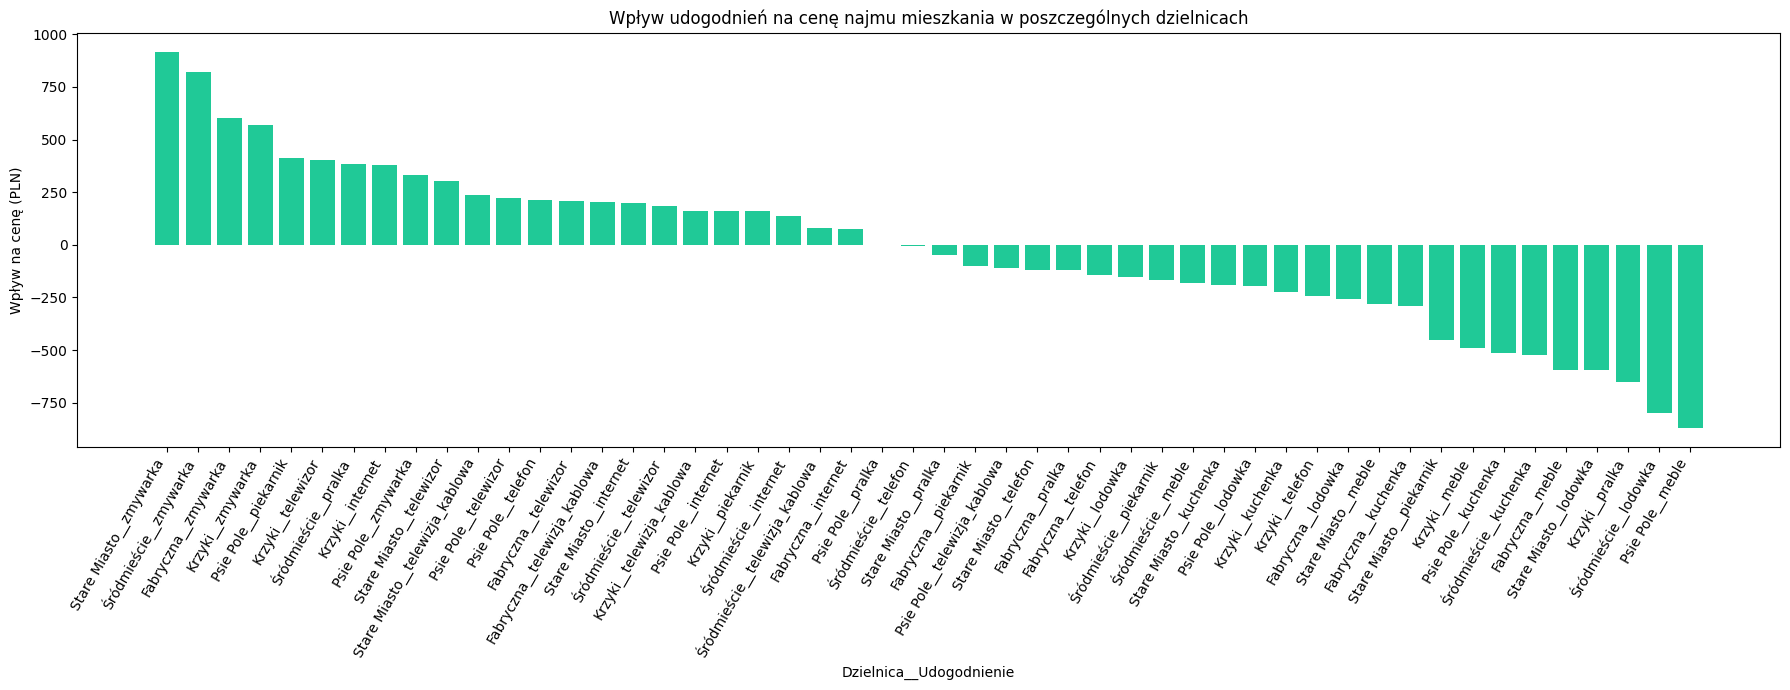

In [71]:
dzielnice_encoded = pd.get_dummies(df['dzielnica'])

interaction_cols = []
for feature in features:
    new_cols = []
    for dzielnica in df['dzielnica'].unique():
        col_name = f"{dzielnica}__{feature}"
        mask = (df['dzielnica'] == dzielnica)
        df[col_name] = df[feature] * mask.astype(int)
        if df[col_name].sum() > 50:
            interaction_cols.append(col_name)
        else:
            df.drop(columns=[col_name], inplace=True)

X = df[interaction_cols]
y = df['cenaPLN']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'interakcja': X.columns,
    'wplyw_na_cene': model.coef_,
    'liczba_wystapien': [df[col].sum() for col in X.columns]
}).sort_values(by='wplyw_na_cene', ascending=False)

results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['interakcja'], results['wplyw_na_cene'], color='#20c997')  # zielonkawy turkusowy
plt.xlabel('Dzielnica__Udogodnienie')
plt.ylabel('Wpływ na cenę (PLN)')
plt.title('Wpływ udogodnień na cenę najmu mieszkania w poszczególnych dzielnicach')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()

Oraz cena za m^2 dla dzielnic i poszczególnych udogodnień:

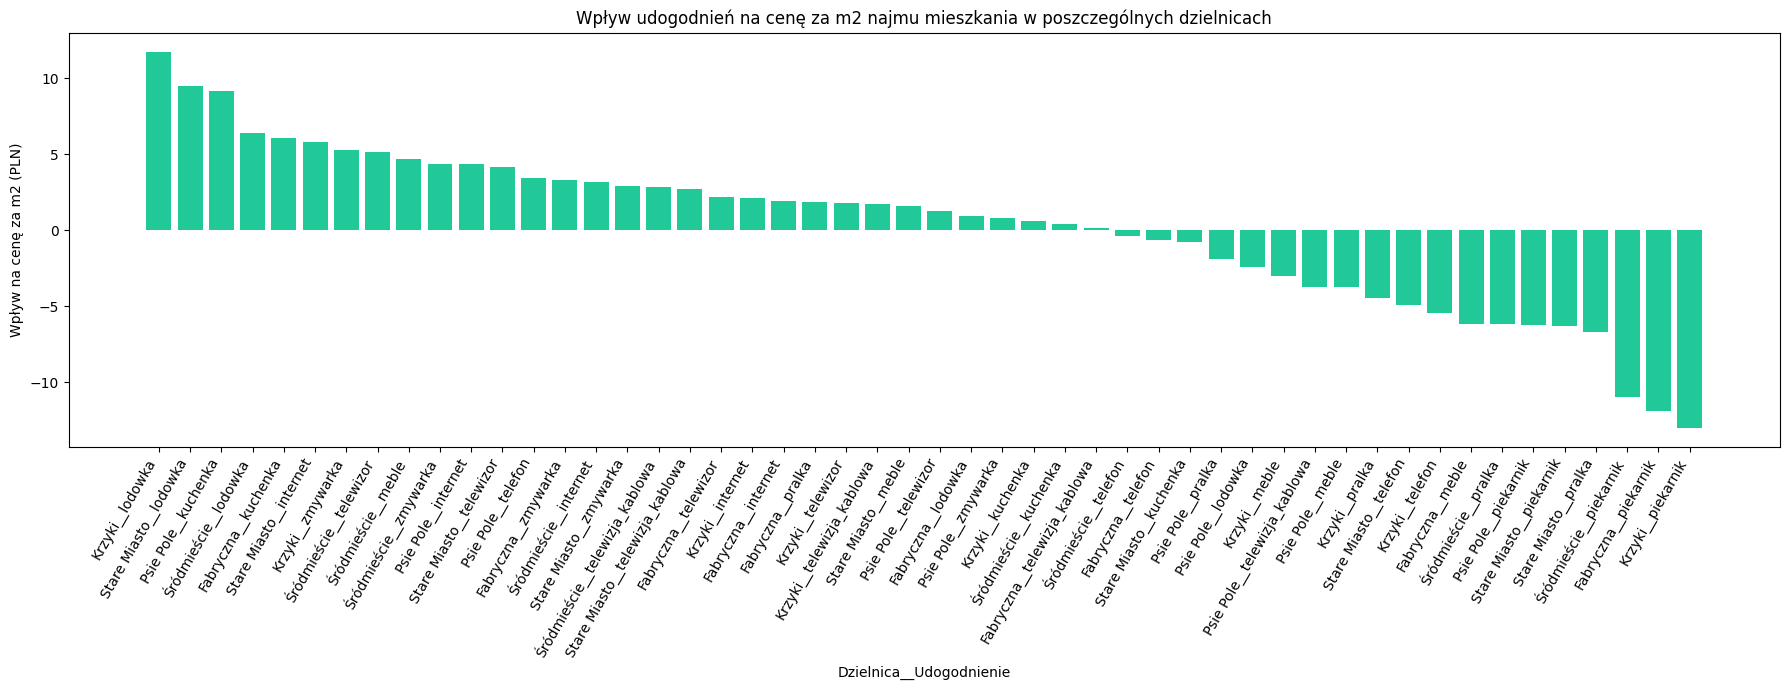

In [72]:
X = df[interaction_cols]
y = df['cena_za_m2']

model = LinearRegression()
model.fit(X, y)

results = pd.DataFrame({
    'interakcja': X.columns,
    'wplyw_na_cene': model.coef_,
    'liczba_wystapien': [df[col].sum() for col in X.columns]
}).sort_values(by='wplyw_na_cene', ascending=False)

results


plt.figure(figsize=(18, 7))  # większy wykres
plt.bar(results['interakcja'], results['wplyw_na_cene'], color='#20c997')  # zielonkawy turkusowy
plt.xlabel('Dzielnica__Udogodnienie')
plt.ylabel('Wpływ na cenę za m2 (PLN)')
plt.title('Wpływ udogodnień na cenę za m2 najmu mieszkania w poszczególnych dzielnicach')
plt.xticks(rotation=60, ha='right', fontsize=10)  # większy obrót i mniejsza czcionka
plt.tight_layout()
plt.show()

Wyniki zostałe obliczone tylko dla kombinacji które mają przynajmniej 50 wystąpień. W przypadku gdy niektóre z nich mają tylko kilka wystąpień, wyniki stają się niewymierne i osiągają absurdalne wartości (np. piekarnik_Siechnice - 1.566843e+16).

Najbardziej opłacalnym w wielu dzielnicach okazała się zmywarka - która dominuje w 4 pierwszych najbardziej opłacalnych kombinacji dzielnic i udogodnień.
Kiedy weźmiemy pod uwagę wielkość mieszkania, zdecydowanym zwycięzcą zostaje lodówka.

## Podsumowanie

Na podstawie przeprowadzonej analizy ofert wynajmu mieszkań we Wrocławiu na podstawie danych z serwisu OTODOM można wyciągnąć następujące wnioski:

### Wpływ pojedynczych udogodnień na cenę:
- Zmywarka okazała się najbardziej opłacalnym udogodnieniem, które znacząco podnosi cenę najmu mieszkania.
- Lodówka, mimo swojej powszechności, zaniża cenę najmu, co może wynikać z jej częstszego występowania w mieszkaniach o niższym standardzie.

### Wpływ pojedynczych udogodnień na cenę za m²:
- W przypadku analizy ceny za m², lodówka jest najbardziej opłacalnym udogodnieniem, co może wynikać z jej częstszego występowania w mniejszych mieszkaniach, które są bardziej nowoczesne i lepiej wyposażone.
- Piekarnik przynosi największą stratę w cenie za m², co może być związane z jego obecnością w starszych lub mniej atrakcyjnych mieszkaniach.

### Wpływ kombinacji udogodnień na cenę:
- Najbardziej opłacalne kombinacje udogodnień to pralka z telefonem, telewizja kablowa z internetem, oraz meble z pralką. Te połączenia znacząco podnoszą cenę najmu.
- Kombinacje lodówki z telefonem lub meblami powodują największe straty na czynszu, co może wynikać z ich częstszego występowania w mieszkaniach o niższym standardzie.

### Wpływ kombinacji udogodnień na cenę za m²:
- Najbardziej opłacalne kombinacje dla ceny za m² to meble z pralką lub telewizorem, oraz lodówka z internetem lub kuchenką.
- Zaskakująco, wiele kombinacji z lodówką przynosi stratę, co może wskazywać na jej obecność w mieszkaniach o niższej jakości.

### Wpływ dzielnic na cenę udogodnień:
- Najbardziej opłacalne udogodnienia często powtarzają się, w 4 różnych dzielnicach najlepszym udogodnieniem jest zmywarka, a jeśli weźmiemy pod uwagę rozmiar mieszkania, 3-krotnie w top 5 powtarza się lodówka.
- Niektóre dzielnice (np. Rynek) są generalnie bardziej opłacalne, bez względu na udogodnienie, niż inne i większe znaczenie mają udogodnienia.

### Ogólne wnioski:
- Udogodnienia takie jak zmywarka, pralka, czy internet mają największy pozytywny wpływ na cenę najmu, zarówno w ujęciu całkowitym, jak i za m².
- Lodówka, mimo swojej powszechności, ma zróżnicowany wpływ – zaniża cenę najmu, ale podnosi cenę za m², co wskazuje na jej różne znaczenie w zależności od typu mieszkania.
- Kombinacje udogodnień mogą znacząco zmieniać opłacalność – warto inwestować w połączenia, które są atrakcyjne dla najemców, np. pralka z meblami lub internet z telewizją kablową.
- Analiza pokazuje, że decyzje dotyczące wyposażenia mieszkania powinny być podejmowane w kontekście jego standardu, lokalizacji oraz docelowej grupy najemców.